# Imports

In [53]:
import os.path as op

import numpy as np

import mne
from mne.datasets import sample

import matplotlib.pyplot as plt

# Data creation excersize

    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading forward solution from /home/ukulele_personal/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    MEG and EEG forward solutions combined
    Source spaces transformed to the forward solution coordinate frame
Reading la

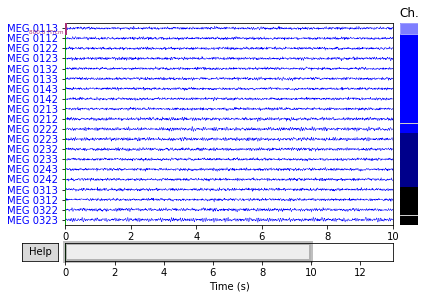

40 events found
Event IDs: [1]
40 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Loading data for 40 events and 151 original time points ...
1 bad epochs dropped


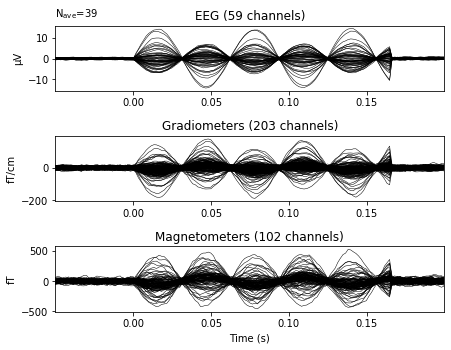

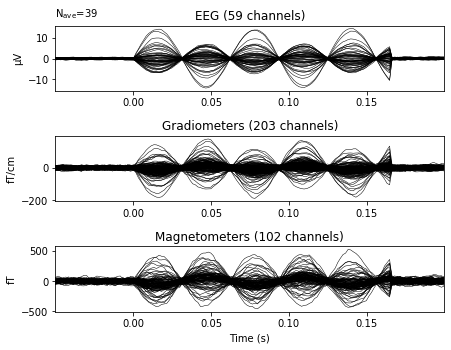

In [85]:
# For this example, we will be using the information of the sample subject.
# This will download the data if it not already on your machine. We also set
# the subjects directory so we don't need to give it to functions.
data_path = sample.data_path()
subjects_dir = op.join(data_path, 'subjects')
subject = 'sample'

# First, we get an info structure from the test subject.
evoked_fname = op.join(data_path, 'MEG', subject, 'sample_audvis-ave.fif')
info = mne.io.read_info(evoked_fname)
tstep = 1. / info['sfreq']

# To simulate sources, we also need a source space. It can be obtained from the
# forward solution of the sample subject.
fwd_fname = op.join(data_path, 'MEG', subject,
                    'sample_audvis-meg-eeg-oct-6-fwd.fif')
fwd = mne.read_forward_solution(fwd_fname)
src = fwd['src']

# To select a region to activate, we use the caudal middle frontal to grow
# a region of interest.
selected_label = mne.read_labels_from_annot(
    subject, regexp='caudalmiddlefrontal-lh', subjects_dir=subjects_dir)[0]
location = 'center'  # Use the center of the region as a seed.
extent = 10.  # Extent in mm of the region.
label = mne.label.select_sources(
    subject, selected_label, location=location, extent=extent,
    subjects_dir=subjects_dir)

# Define the time course of the activity for each source of the region to
# activate. Here we use a sine wave at 18 Hz with a peak amplitude
# of 10 nAm.
source_time_series = np.sin(2. * np.pi * 16. * np.arange(100) * tstep) * 10e-9

# Define when the activity occurs using events. The first column is the sample
# of the event, the second is not used, and the third is the event id. Here the
# events occur every 200 samples.
n_events = 40
events = np.zeros((n_events, 3))
events[:, 0] = 100 + 200 * np.arange(n_events)  # Events sample.
events[:, 2] = 1  # All events have the sample id.

# Create simulated source activity. Here we use a SourceSimulator whose
# add_data method is key. It specified where (label), what
# (source_time_series), and when (events) an event type will occur.
source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep)
source_simulator.add_data(label, source_time_series, events)

# Project the source time series to sensor space and add some noise. The source
# simulator can be given directly to the simulate_raw function.
raw = mne.simulation.simulate_raw(info, source_simulator, forward=fwd)
cov = mne.make_ad_hoc_cov(raw.info)
mne.simulation.add_noise(raw, cov, iir_filter=[0.2, -0.2, 0.04])
raw.plot()

# Plot evoked data to get another view of the simulated raw data.
events = mne.find_events(raw)
epochs = mne.Epochs(raw, events, 1, tmin=-0.05, tmax=0.2, preload=True)
evoked = epochs.average()
evoked.plot(show=True)


In [39]:
eeg = evoked.copy().pick_types(meg=False, eeg=True, eog=False)

In [40]:
eeg = eeg.pick_channels(['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 008', 'EEG 009', 'EEG 0010', 'EEG 011', 'EEG 012', 'EEG 013', 'EEG 014', 'EEG 015', 'EEG 016', 'EEG 017', 'EEG 018', 'EEG 019', ])

In [41]:
eeg.info

<Info | 14 non-empty values
 bads: []
 ch_names: EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, EEG 007, ...
 chs: 18 EEG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 18
 projs: PCA-v1: on, PCA-v2: on, PCA-v3: on, Average EEG reference: on
 sfreq: 600.6 Hz
>

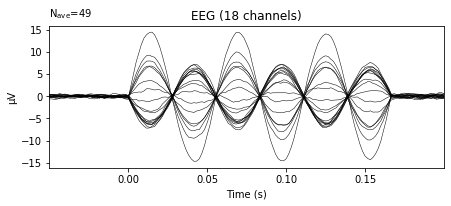

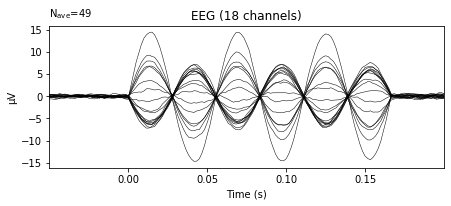

In [42]:
eeg.plot(show=True)

In [43]:
eeg.data.shape

(18, 151)

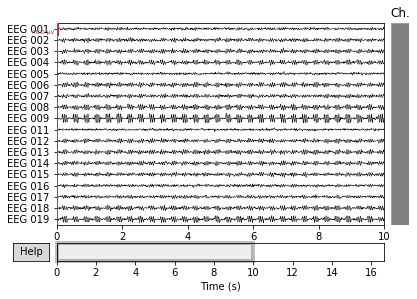

(18, 10000)

In [44]:
eeg_raw = raw.copy().pick_types(meg=False, eeg=True, eog=False)
eeg_raw = eeg_raw.pick_channels(['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 008', 'EEG 009', 'EEG 0010', 'EEG 011', 'EEG 012', 'EEG 013', 'EEG 014', 'EEG 015', 'EEG 016', 'EEG 017', 'EEG 018', 'EEG 019', ])
eeg_raw.plot(show=True)
eeg_raw.get_data().shape

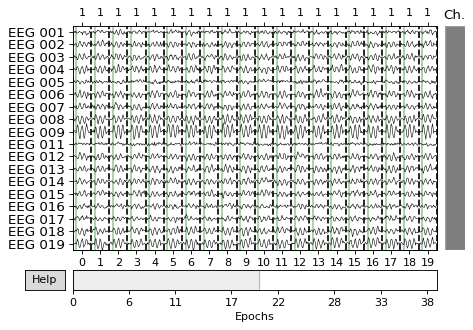

(39, 18, 151)

In [86]:
eeg_epochs = epochs.copy().pick_types(meg=False, eeg=True, eog=False,)
eeg_epochs = eeg_epochs.pick_channels(['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 008', 'EEG 009', 'EEG 0010', 'EEG 011', 'EEG 012', 'EEG 013', 'EEG 014', 'EEG 015', 'EEG 016', 'EEG 017', 'EEG 018', 'EEG 019', ])
eeg_epochs.plot(show=True)
eeg_epochs_data = eeg_epochs.get_data()
eeg_epochs_data.shape

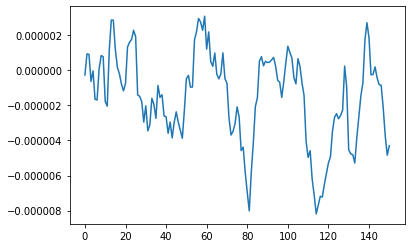

In [87]:
plt.plot(eeg_epochs_data[0,0,:])

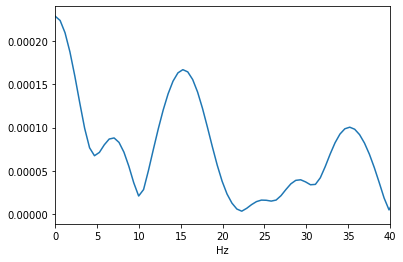

In [88]:
import scipy.signal as ss
b = eeg_epochs_data[0,0,:]
f, h0= ss.freqz(b, a=1, worN=512, whole=False,  fs=words.info['sfreq'])


plt.figure()
plt.plot(f, abs(h0))
plt.xlabel('Hz')
plt.xlim((0,40))
plt.show()

# Data creation

In [89]:
def simulate_data(number_of_events, simulated_frequency):
    # For this example, we will be using the information of the sample subject.
    # This will download the data if it not already on your machine. We also set
    # the subjects directory so we don't need to give it to functions.
    data_path = sample.data_path()
    subjects_dir = op.join(data_path, 'subjects')
    subject = 'sample'

    # First, we get an info structure from the test subject.
    evoked_fname = op.join(data_path, 'MEG', subject, 'sample_audvis-ave.fif')
    info = mne.io.read_info(evoked_fname)
    tstep = 1. / info['sfreq']

    # To simulate sources, we also need a source space. It can be obtained from the
    # forward solution of the sample subject.
    fwd_fname = op.join(data_path, 'MEG', subject,
                        'sample_audvis-meg-eeg-oct-6-fwd.fif')
    fwd = mne.read_forward_solution(fwd_fname)
    src = fwd['src']

    # To select a region to activate, we use the caudal middle frontal to grow
    # a region of interest.
    selected_label = mne.read_labels_from_annot(
        subject, regexp='caudalmiddlefrontal-lh', subjects_dir=subjects_dir)[0]
    location = 'center'  # Use the center of the region as a seed.
    extent = 10.  # Extent in mm of the region.
    label = mne.label.select_sources(
        subject, selected_label, location=location, extent=extent,
        subjects_dir=subjects_dir)

    # Define the time course of the activity for each source of the region to
    # activate. Here we use a sine wave at 18 Hz with a peak amplitude
    # of 10 nAm.
    source_time_series = np.sin(2. * np.pi * simulated_frequency * np.arange(100) * tstep) * 10e-9

    # Define when the activity occurs using events. The first column is the sample
    # of the event, the second is not used, and the third is the event id. Here the
    # events occur every 200 samples.
    n_events = number_of_events
    events = np.zeros((n_events, 3))
    events[:, 0] = 100 + 200 * np.arange(n_events)  # Events sample.
    events[:, 2] = 1  # All events have the sample id.

    # Create simulated source activity. Here we use a SourceSimulator whose
    # add_data method is key. It specified where (label), what
    # (source_time_series), and when (events) an event type will occur.
    source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep)
    source_simulator.add_data(label, source_time_series, events)

    # Project the source time series to sensor space and add some noise. The source
    # simulator can be given directly to the simulate_raw function.
    raw = mne.simulation.simulate_raw(info, source_simulator, forward=fwd)
    cov = mne.make_ad_hoc_cov(raw.info)
    mne.simulation.add_noise(raw, cov, iir_filter=[0.2, -0.2, 0.04])

    # Plot evoked data to get another view of the simulated raw data.
    events = mne.find_events(raw)
    epochs = mne.Epochs(raw, events, 1, tmin=-0.05, tmax=0.2, preload=True)
    evoked = epochs.average()
    eeg_epochs = epochs.copy().pick_types(meg=False, eeg=True, eog=False,)
    eeg_epochs = eeg_epochs.pick_channels(['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 008', 'EEG 009', 'EEG 0010', 'EEG 011', 'EEG 012', 'EEG 013', 'EEG 014', 'EEG 015', 'EEG 016', 'EEG 017', 'EEG 018', 'EEG 019', ])
    return eeg_epochs

In [102]:
words = simulate_data(1200, 18.)

    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading forward solution from /home/ukulele_personal/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    MEG and EEG forward solutions combined
    Source spaces transformed to the forward solution coordinate frame
Reading la

    Interval 346.312-347.977 sec
    Interval 347.977-349.642 sec
    Interval 349.642-351.307 sec
    Interval 351.307-352.972 sec
    Interval 352.972-354.637 sec
    Interval 354.637-356.301 sec
    Interval 356.301-357.966 sec
    Interval 357.966-359.631 sec
    Interval 359.631-361.296 sec
    Interval 361.296-362.961 sec
    Interval 362.961-364.626 sec
    Interval 364.626-366.291 sec
    Interval 366.291-367.956 sec
    Interval 367.956-369.621 sec
    Interval 369.621-371.286 sec
    Interval 371.286-372.951 sec
    Interval 372.951-374.616 sec
    Interval 374.616-376.281 sec
    Interval 376.281-377.946 sec
    Interval 377.946-379.611 sec
    Interval 379.611-381.276 sec
    Interval 381.276-382.941 sec
    Interval 382.941-384.606 sec
    Interval 384.606-386.271 sec
    Interval 386.271-387.936 sec
    Interval 387.936-389.601 sec
    Interval 389.601-391.266 sec
    Interval 391.266-392.931 sec
    Interval 392.931-394.596 sec
    Interval 394.596-396.261 sec
    Interv

In [103]:
pseudo = simulate_data(1200, 7.)

    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
Reading forward solution from /home/ukulele_personal/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    MEG and EEG forward solutions combined
    Source spaces transformed to the forward solution coordinate frame
Reading la

    Interval 346.312-347.977 sec
    Interval 347.977-349.642 sec
    Interval 349.642-351.307 sec
    Interval 351.307-352.972 sec
    Interval 352.972-354.637 sec
    Interval 354.637-356.301 sec
    Interval 356.301-357.966 sec
    Interval 357.966-359.631 sec
    Interval 359.631-361.296 sec
    Interval 361.296-362.961 sec
    Interval 362.961-364.626 sec
    Interval 364.626-366.291 sec
    Interval 366.291-367.956 sec
    Interval 367.956-369.621 sec
    Interval 369.621-371.286 sec
    Interval 371.286-372.951 sec
    Interval 372.951-374.616 sec
    Interval 374.616-376.281 sec
    Interval 376.281-377.946 sec
    Interval 377.946-379.611 sec
    Interval 379.611-381.276 sec
    Interval 381.276-382.941 sec
    Interval 382.941-384.606 sec
    Interval 384.606-386.271 sec
    Interval 386.271-387.936 sec
    Interval 387.936-389.601 sec
    Interval 389.601-391.266 sec
    Interval 391.266-392.931 sec
    Interval 392.931-394.596 sec
    Interval 394.596-396.261 sec
    Interv

In [104]:
pseudo_data = pseudo.get_data()
words_data = words.get_data()
divider = 1000
X_pseudo_train = pseudo_data[:divider]
X_word_train = words_data[:divider]
X_pseudo_test = pseudo_data[divider:]
X_word_test = words_data[divider:]

In [105]:
output = './processed_data/'
data_type = 'simulated'
np.save(output + f'X_pseudo_test_{data_type}.npy', X_pseudo_test)
np.save(output + f'X_word_test_{data_type}.npy', X_word_test)
np.save(output + f'X_pseudo_train_{data_type}.npy', X_pseudo_train)
np.save(output + f'X_word_train_{data_type}.npy', X_word_train)

In [93]:
words.info['sfreq']

600.614990234375

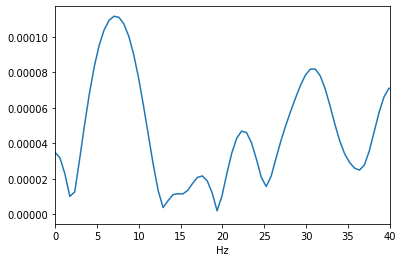

In [106]:
b = pseudo_data[0,0,:]
f, h0= ss.freqz(b, a=1, worN=512, whole=False,  fs=words.info['sfreq'])


plt.figure()
plt.plot(f, abs(h0))
plt.xlabel('Hz')
plt.xlim((0,40))
plt.show()

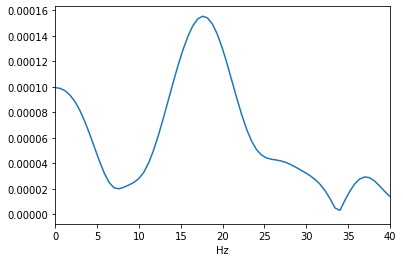

In [107]:
b = words_data[0,0,:]
f, h0= ss.freqz(b, a=1, worN=512, whole=False,  fs=words.info['sfreq'])


plt.figure()
plt.plot(f, abs(h0))
plt.xlabel('Hz')
plt.xlim((0,40))
plt.show()